<h1 style="text-align :center">Titanic Classification</h1>

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import pandas_datareader as web
from copy import deepcopy
from sklearn.model_selection import train_test_split
import math
import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from keras.layers import Dense, LSTM
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

### Importing the Data

In [2]:
# create seperate dataframes that hold the training and test sets
titanic = pd.read_csv('train.csv')
titanic_test = pd.read_csv('test.csv')

In [3]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
titanic.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [5]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
titanic.describe().T               

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


In [7]:
# total number of people who survived vs. died
titanic['Survived'].value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

### Exploratory Data Analysis

#### Missing Data

<Axes: >

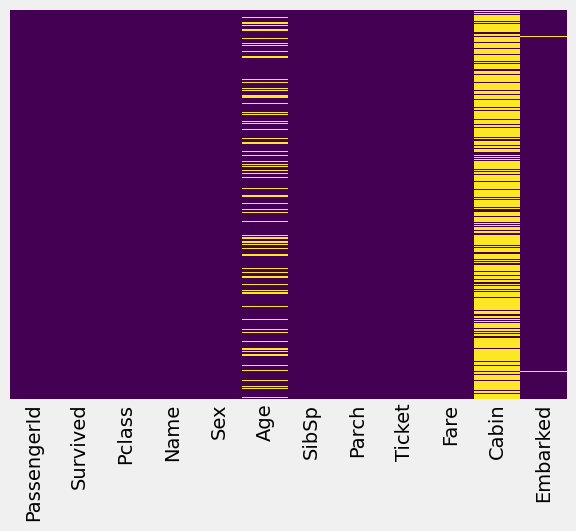

In [8]:
sns.heatmap(titanic.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [9]:
titanic.isnull().sum().sort_values(ascending=False)

Cabin          687
Age            177
Embarked         2
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Ticket           0
Fare             0
dtype: int64

<Axes: xlabel='Survived', ylabel='count'>

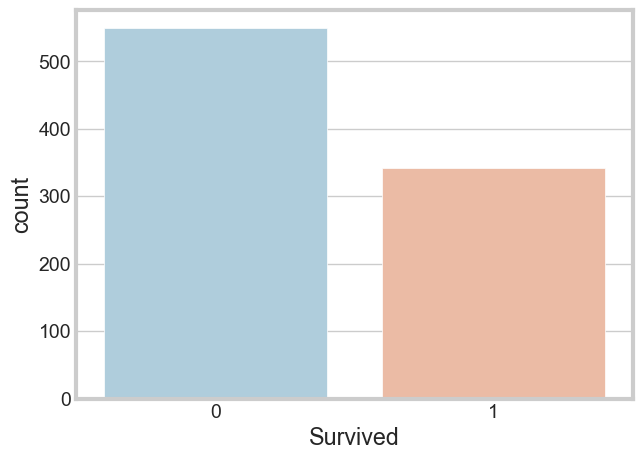

In [10]:
sns.set_style('whitegrid')
sns.countplot(x='Survived', data=titanic, palette='RdBu_r')

<Axes: xlabel='Survived', ylabel='count'>

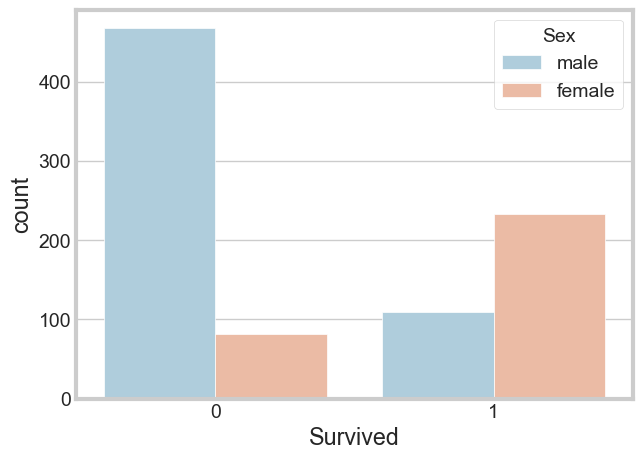

In [11]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Sex',data=titanic,palette='RdBu_r')

<Axes: >

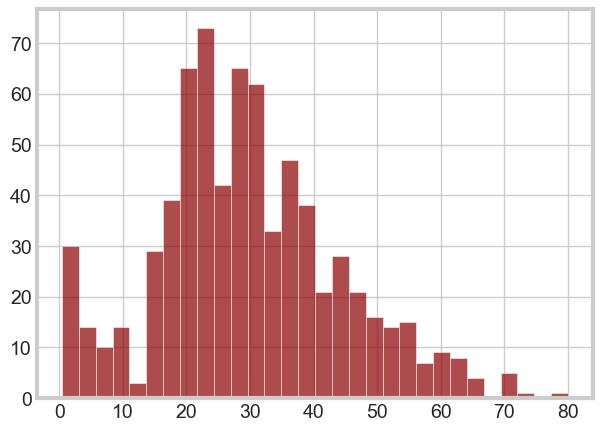

In [12]:
titanic['Age'].hist(bins=30,color='darkred',alpha=0.7)

<Axes: xlabel='SibSp', ylabel='count'>

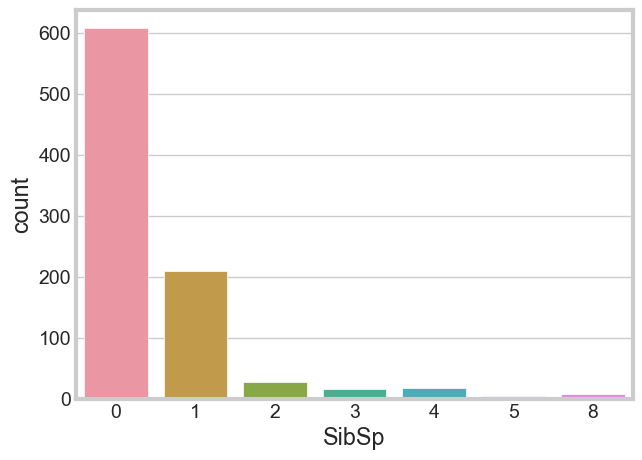

In [13]:
sns.countplot(x='SibSp',data=titanic)

<Axes: xlabel='Parch', ylabel='count'>

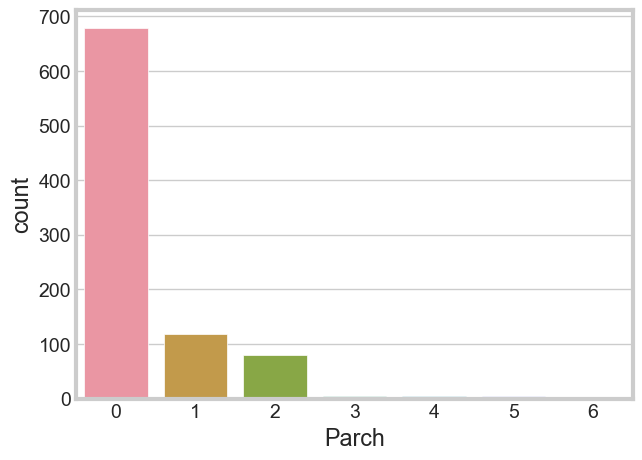

In [14]:
sns.countplot(x='Parch',data=titanic)

<Axes: >

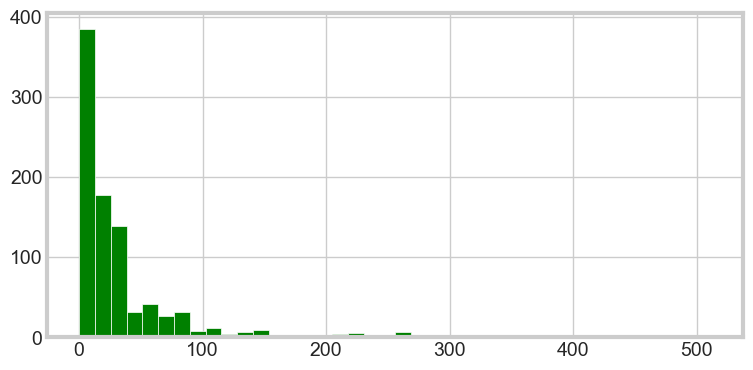

In [15]:
titanic['Fare'].hist(color='green',bins=40,figsize=(8,4))

### Data Cleaning

<Axes: xlabel='Pclass', ylabel='Age'>

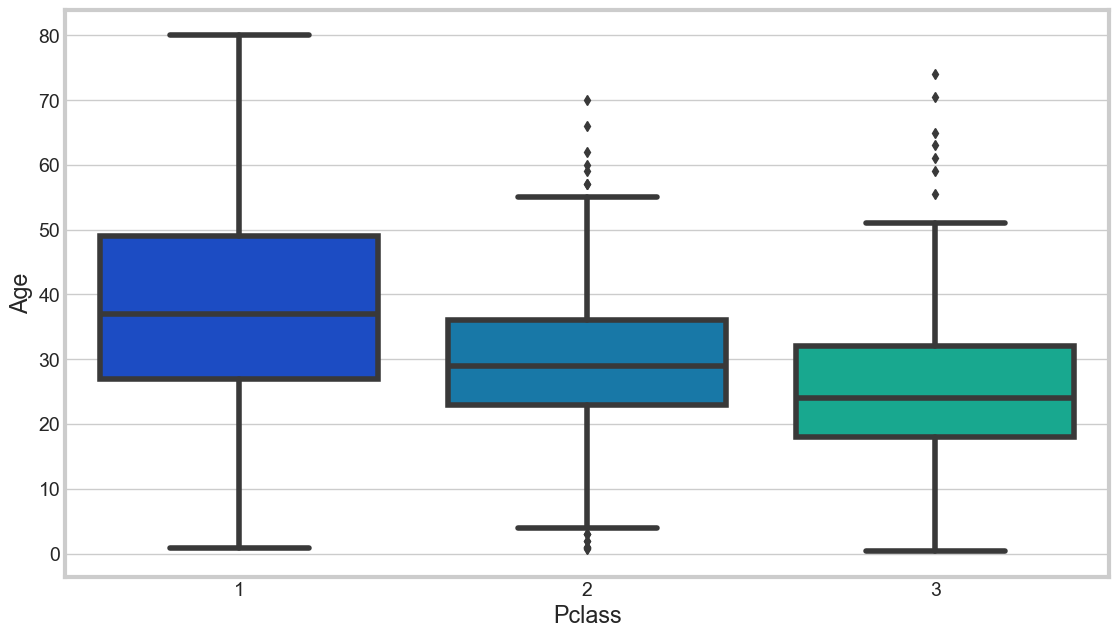

In [16]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='Pclass',y='Age',data=titanic,palette='winter')

In [17]:
def impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):
        if Pclass == 1:
            return titanic[titanic['Pclass'] == 1]['Age'].median()
        elif Pclass == 2:
            return titanic[titanic['Pclass'] == 2]['Age'].median()
        else:
            return titanic[titanic['Pclass'] == 3]['Age'].median()
    else:
        return Age

In [18]:
titanic['Age'] = titanic[['Age','Pclass']].apply(impute_age,axis=1)

In [19]:
titanic['Embarked'] = titanic['Embarked'].fillna('S')

Now let's check that heat map again!

<Axes: >

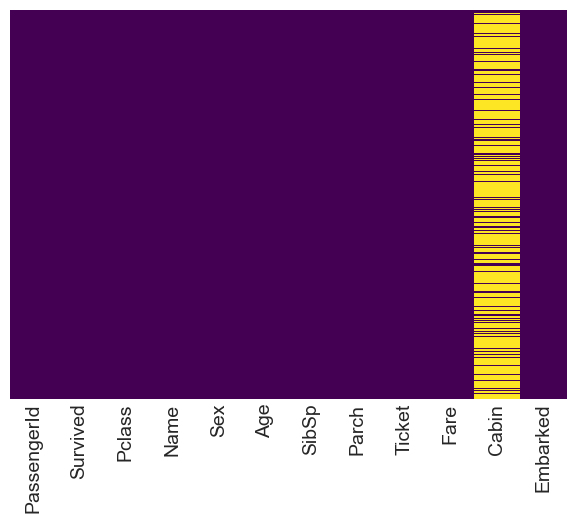

In [20]:
sns.heatmap(titanic.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Let's go ahead and drop the Cabin column and the row in Embarked that is NaN.

In [21]:
titanic.drop('Cabin',axis=1,inplace=True)

In [22]:
titanic.dropna(inplace=True)

In [23]:
titanic

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S
...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,24.0,1,2,W./C. 6607,23.4500,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C


#### Converting Categorical Features

In [24]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Embarked     891 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 76.7+ KB


In [25]:
sex = pd.get_dummies(titanic['Sex'], drop_first=True).astype(int)
embark = pd.get_dummies(titanic['Embarked'], drop_first=True).astype(int)

In [26]:
titanic.drop(['Sex','Embarked','Name','Ticket'],axis=1,inplace=True)

In [27]:
titanic = pd.concat([titanic,sex,embark],axis=1)

In [28]:
titanic.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,1,0,3,22.0,1,0,7.2500,1,0,1
1,2,1,1,38.0,1,0,71.2833,0,0,0
2,3,1,3,26.0,0,0,7.9250,0,0,1
3,4,1,1,35.0,1,0,53.1000,0,0,1
4,5,0,3,35.0,0,0,8.0500,1,0,1


#### 1- Logistic Regression model

Train Test Split

In [29]:
features = titanic.drop(['Survived'],axis=1)
target = titanic['Survived']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.10, random_state=101)

Training and Predicting

In [30]:
from sklearn.linear_model import LogisticRegression

logmodel = LogisticRegression()
logmodel.fit(X_train, y_train)

LogisticRegression()

In [31]:
predictions = logmodel.predict(X_test)
X_test.head()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,male,Q,S
331,332,1,45.5,0,0,28.500,1,0,1
700,701,1,18.0,1,0,227.525,0,0,0
748,749,1,19.0,1,0,53.100,1,0,1
751,752,3,6.0,0,1,12.475,1,0,1
481,482,2,29.0,0,0,0.000,1,0,1


In [32]:
predictions

array([0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 1], dtype=int64)

Evaluation

We can check precision,recall,f1-score using classification report!

In [33]:
from sklearn.metrics import classification_report,confusion_matrix

In [34]:
print(confusion_matrix(y_test,predictions))

[[45  6]
 [16 23]]


In [35]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.74      0.88      0.80        51
           1       0.79      0.59      0.68        39

    accuracy                           0.76        90
   macro avg       0.77      0.74      0.74        90
weighted avg       0.76      0.76      0.75        90



#### 2- Decision Tree Classifiction

In [36]:
from sklearn.tree import DecisionTreeClassifier

In [37]:
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)

DecisionTreeClassifier()

In [38]:
dt_predictions = dt_model.predict(X_test)

In [39]:
dt_predictions

array([0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1,
       0, 1], dtype=int64)

In [40]:
print(confusion_matrix(y_test,dt_predictions))

[[42  9]
 [15 24]]


In [41]:
print(classification_report(y_test,dt_predictions))

              precision    recall  f1-score   support

           0       0.74      0.82      0.78        51
           1       0.73      0.62      0.67        39

    accuracy                           0.73        90
   macro avg       0.73      0.72      0.72        90
weighted avg       0.73      0.73      0.73        90



#### 3- Random Forest Classification

In [42]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=500)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500)

In [43]:
rf_pre=rf.predict(X_test)

In [44]:
print(confusion_matrix(y_test,rf_pre))

[[48  3]
 [14 25]]


In [45]:
print(classification_report(y_test,rf_pre))

              precision    recall  f1-score   support

           0       0.77      0.94      0.85        51
           1       0.89      0.64      0.75        39

    accuracy                           0.81        90
   macro avg       0.83      0.79      0.80        90
weighted avg       0.83      0.81      0.80        90



#### 4- XGBoosts Classifier

In [46]:
from xgboost import XGBClassifier
xgboost = XGBClassifier(n_estimators=1000)
xgboost.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [47]:
xg_pred = xgboost.predict(X_test)

In [48]:
print(confusion_matrix(y_test,xg_pred))

[[46  5]
 [15 24]]


In [49]:
print(classification_report(y_test,xg_pred))

              precision    recall  f1-score   support

           0       0.75      0.90      0.82        51
           1       0.83      0.62      0.71        39

    accuracy                           0.78        90
   macro avg       0.79      0.76      0.76        90
weighted avg       0.79      0.78      0.77        90



#### 5- ANN 

In [50]:
import keras 
from keras.layers import Dense
from keras.models import Sequential

In [56]:
ann = Sequential()
ann.add(Dense(units=32, kernel_initializer='uniform', activation='relu', input_dim=9))
ann.add(Dense(units=32, kernel_initializer='uniform', activation='relu'))
ann.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))
ann.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [59]:
ann.fit(X_train, y_train, batch_size=32, epochs=300, verbose=0)

In [60]:
ann_pred = ann.predict(X_test)
ann_pred = [ 1 if y>=0.5 else 0 for y in ann_pred]
print(ann_pred)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
[0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1]


In [61]:
print(confusion_matrix(y_test,ann_pred))

[[44  7]
 [13 26]]


In [62]:
print(classification_report(y_test,ann_pred))

              precision    recall  f1-score   support

           0       0.77      0.86      0.81        51
           1       0.79      0.67      0.72        39

    accuracy                           0.78        90
   macro avg       0.78      0.76      0.77        90
weighted avg       0.78      0.78      0.77        90



## => Test 

<Axes: >

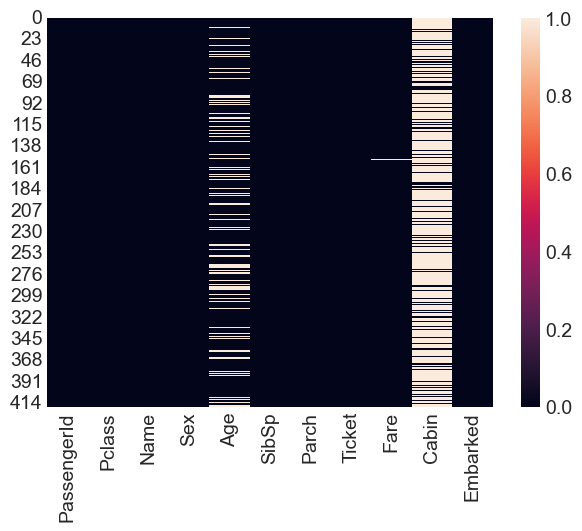

In [63]:
sns.heatmap(titanic_test.isnull())

In [64]:
titanic_test.drop('Cabin',axis=1,inplace=True)

In [65]:
titanic_test['Fare'].fillna(titanic_test['Fare'].median(), inplace=True)

In [66]:
titanic_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         418 non-null    float64
 9   Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(4)
memory usage: 32.8+ KB


In [67]:
titanic_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,S


In [68]:
titanic_test['Age'] = titanic_test[['Age','Pclass']].apply(impute_age,axis=1)

In [69]:
sex_test = pd.get_dummies(titanic_test['Sex'],drop_first=True)
embark_test= pd.get_dummies(titanic_test['Embarked'],drop_first=True)

In [70]:
titanic_test.drop(['Sex','Embarked','Name','Ticket'],axis=1,inplace=True)

In [71]:
titanic_test = pd.concat([titanic_test,sex_test,embark_test],axis=1)

In [72]:
titanic_test.head()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,892,3,34.5,0,0,7.8292,True,True,False
1,893,3,47.0,1,0,7.0000,False,False,True
2,894,2,62.0,0,0,9.6875,True,True,False
3,895,3,27.0,0,0,8.6625,True,False,True
4,896,3,22.0,1,1,12.2875,False,False,True


In [80]:
ann.fit(titanic.drop(['Survived'], axis=1), titanic['Survived'], epochs=300, verbose=0)

In [81]:
test_prediction = ann.predict(titanic_test)
test_prediction = [ 1 if y>=0.5 else 0 for y in test_prediction]

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step


In [91]:
test_pred = pd.DataFrame(test_prediction, columns= ['Survived'])

In [92]:
new_test = pd.concat([titanic_test, test_pred], axis=1, join='inner')
new_test

,PassengerId,Pclass,Age,SibSp,Parch,Fare,male,Q,S,Survived
0,892,3,34.5,0,0,7.8292,True,True,False,0
1,893,3,47.0,1,0,7.0000,False,False,True,0
2,894,2,62.0,0,0,9.6875,True,True,False,0
3,895,3,27.0,0,0,8.6625,True,False,True,0
4,896,3,22.0,1,1,12.2875,False,False,True,1
...,...,...,...,...,...,...,...,...,...,...
413,1305,3,24.0,0,0,8.0500,True,False,True,1
414,1306,1,39.0,0,0,108.9000,False,False,False,1
415,1307,3,38.5,0,0,7.2500,True,False,True,0
416,1308,3,24.0,0,0,8.0500,True,False,True,1
